In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns 

/Users/jieruohe/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# price and volume

In [3]:
# tpphrm index daily data
tpphrm_price = pd.read_excel('TPPHRM daily price and volume.xlsx', parse_dates=['Date'], index_col='Date')['PX_LAST']
#tpphrm_price.set_index('date', inplace=True)
tpphrm_rtn = tpphrm_price.pct_change()

In [4]:
# Convert stock list to Yahoo Finance symbols
stock_symbols =  [
    "4151.T", "4501.T", "4502.T", "4503.T", "4505.T", "4506.T", "4507.T", "4508.T",
    "4509.T", "4511.T", "4512.T", "4514.T", "4516.T", "4517.T", "4518.T", "4519.T",
    "4521.T", "4523.T", "4527.T", "4528.T", "4529.T", "4530.T", "4531.T", "4534.T",
    "4535.T", "4536.T", "4537.T", "4538.T", "4539.T", "4540.T", "4541.T", "4544.T",
    "4547.T", "4548.T", "4549.T", "4550.T", "4551.T", "4552.T", "4553.T", "4554.T",
    "4555.T", "4559.T", "4560.T", "4565.T", "4568.T", "4569.T", "4574.T", "4577.T",
    "4578.T", "4581.T", "4587.T", "4880.T", "4886.T", "4887.T"
]

# Download stock data
def download_stock_data(symbols,index,interval = '1d'):
    data = yf.download(symbols, start="2005-01-01", end="2024-03-01", interval=interval)
    return data[index]

price_data = download_stock_data(stock_symbols,"Adj Close")
vol_data = download_stock_data(stock_symbols,"Volume")
df_rtn = price_data.pct_change() #.dropna()
df_rtn_1mo = download_stock_data(stock_symbols,"Adj Close",'1mo').pct_change()

[*********************100%%**********************]  54 of 54 completed

15 Failed downloads:
['4501.T', '4529.T', '4505.T', '4511.T', '4537.T', '4535.T', '4509.T', '4560.T', '4518.T']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-01)')
['4555.T', '4514.T', '4517.T', '4541.T', '4550.T', '4508.T']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  54 of 54 completed

15 Failed downloads:
['4501.T', '4537.T', '4529.T', '4511.T', '4505.T', '4509.T', '4535.T', '4560.T', '4518.T']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-01)')
['4514.T', '4555.T', '4541.T', '4550.T', '4508.T', '4517.T']: Exception('%ticker%: No timezone found, symbol may be delisted')
[*********************100%%**********************]  54 of 54 completed

15 Failed downloads:
['4514.T', '4555.T', '4517.T', '4541.T', '4550.T', '4508.T']: Exception('%ticker%: No tim

In [5]:
vol_data = vol_data.apply(pd.to_numeric, errors='coerce')
df_rtn = df_rtn.apply(pd.to_numeric, errors='coerce')
df_rtn_1mo = df_rtn_1mo.apply(pd.to_numeric, errors='coerce')

In [6]:
# This function normalizes panel cross-sections to have mean 0, variance 1.
def normalize(panel_data):
    return panel_data.sub(panel_data.mean(axis=1), axis=0).div(panel_data.std(axis=1),axis=0)

# This "winsorizes" the normalized signals, i.e. capping their absolute values.
def winsorizes(panel_data,cap = 0.5):
    return np.minimum(np.maximum(panel_data, -cap), cap)

# This function do data cleaning (normalizes and winsorizes) and takes a panel of positions and returns a time series of returns (in $).
def returns_from_positions(factor, df_rtn, cap=0.5):
    sig_norm = normalize(factor)
    sig_winsor = winsorizes(sig_norm,cap)#.dropna(how='all')
    
    #new_index = df_rtn.index.union(sig_winsor.index)
    #sig_winsor_reindexed = sig_winsor.reindex(new_index, method='ffill')
    
    return (sig_winsor * df_rtn).sum(axis=1)

# This function takes a time series of daily returns & returns an annualized Sharpe ratio.
def sharpe_ratio(daily_return_series , f = 252):
    return round(daily_return_series.mean() / daily_return_series.std() * f**0.5, 2)

# calculate raw momtumn factor
def cal_raw_mom(df_rtn, window,shift_days=1):
    mom_sig_raw = df_rtn.shift(shift_days).rolling(window).sum()
    return mom_sig_raw

# calculate raw cpv factor (cpv: correlation between price change (return) and volume)
def cal_cpv(df_rtn,vol, window):
    vol = vol.fillna(method='ffill')
    vol_norm = vol.shift(1) / vol.shift(1).rolling(window=window).mean()
    cpv_sig_raw = -df_rtn.shift(1).rolling(window=window).corr(vol_norm)
    return cpv_sig_raw

def cal_beta(df_rtn,index_return, window):
    combine_df = pd.merge(df_rtn, index_return, left_index=True, right_index=True, how='left')
    var_idx = combine_df['PX_LAST'].rolling(window=window).var()
    cov = combine_df[stock_symbols].rolling(window=window).cov(combine_df['PX_LAST'])
    return cov.div(var_idx, axis=0).shift(1)

In [11]:
factor_returns_daily = pd.DataFrame(index=df_rtn.index)
# factor_vol_and_price = pd.DataFrame(index=df_rtn.index)

# factor_vol_and_price['mom_1yr_sub_1mon'] = cal_raw_mom(df_rtn,231,22)
# factor_vol_and_price['mom_1mo'] = cal_raw_mom(df_rtn,22)
# factor_vol_and_price['mom_1yr'] = cal_raw_mom(df_rtn,252)
# factor_vol_and_price['mom_1w'] = cal_raw_mom(df_rtn,5)
# factor_vol_and_price['cpv_1w'] = cal_cpv(df_rtn,vol_data,5)
# factor_vol_and_price['cpv_1mo'] = cal_cpv(df_rtn,vol_data,22)
# factor_vol_and_price['cpv_3mo'] = cal_cpv(df_rtn,vol_data,66)
# factor_vol_and_price['beta_1w'] = cal_beta(df_rtn,tpphrm_rtn,5)
# factor_vol_and_price['beta_1mo'] = cal_beta(df_rtn,tpphrm_rtn,22)

# daily factor's factor return
factor_returns_daily['mom_1yr_sub_1mon'] = returns_from_positions(cal_raw_mom(df_rtn,231,22),df_rtn)
factor_returns_daily['mr_1mo'] = returns_from_positions(-cal_raw_mom(df_rtn,22),df_rtn)
factor_returns_daily['mom_1yr'] = returns_from_positions(cal_raw_mom(df_rtn,252),df_rtn)
factor_returns_daily['mr_1w'] = returns_from_positions(-cal_raw_mom(df_rtn,5),df_rtn)
factor_returns_daily['cpv_1w'] = returns_from_positions(cal_cpv(df_rtn,vol_data,5),df_rtn)
factor_returns_daily['cpv_1mo'] = returns_from_positions(cal_cpv(df_rtn,vol_data,22),df_rtn)
factor_returns_daily['cpv_3mo'] = returns_from_positions(cal_cpv(df_rtn,vol_data,66),df_rtn)
factor_returns_daily['beta_1w'] = returns_from_positions(cal_beta(df_rtn,tpphrm_rtn,5),df_rtn)
factor_returns_daily['beta_1mo'] = returns_from_positions(cal_beta(df_rtn,tpphrm_rtn,22),df_rtn)

In [17]:
factor_returns_daily = factor_returns_daily.reset_index().rename(columns={'Date':'date'}).set_index('date')


In [18]:
factor_returns_daily

,mom_1yr_sub_1mon,mr_1mo,mom_1yr,mr_1w,cpv_1w,cpv_1mo,cpv_3mo,beta_1w,beta_1mo
date,,,,,,,,,
2005-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2024-02-22,0.017518,0.038481,0.013008,-0.002788,0.009825,0.003484,-0.002813,0.003928,0.002585
2024-02-26,0.024789,-0.058820,0.036480,-0.047276,-0.111226,-0.021871,0.058828,0.016248,0.022300
2024-02-27,-0.082318,-0.008010,-0.054347,-0.074746,-0.071924,0.115369,0.104273,0.041875,-0.078238


In [20]:
def cut_off(df):
    cutoff_date = pd.to_datetime('2005-03-02')
    df_filtered = df[df.index >= cutoff_date]
    return df_filtered

factor_and_return_daily_yf_data = cut_off(factor_returns_daily)

In [21]:
 #pip install openpyxl

In [22]:
# Step 1: Load Excel files into DataFrames
folder_path = 'yearly fundamental data'
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
dfs = []

for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path, index_col=None, engine='openpyxl')  # Ensure the first column is not set as index
    dfs.append(df)



In [23]:
# Step 2: Clean column names
for df in dfs:
    df.columns = [col.replace('\n', '') if col not in ['Ticker', 'Name', 'Weight', 'Shares', 'Price'] else col for col in df.columns]

# Step 3: Convert file names to date and add as a new column with human-readable format
for file, df in zip(excel_files, dfs):
    date_str = file.split('.')[0]  # Assuming file name format is 'yyyymmdd.xlsx'
    timestamp = datetime.strptime(date_str, '%Y%m%d')
    formatted_timestamp = timestamp.strftime('%Y-%m-%d')
    df['date'] = formatted_timestamp


In [24]:
# Step 4: Convert data types and handle missing values
for df in dfs:
    for col in df.columns:
        if col not in ['Ticker', 'Name','date']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df.fillna(df.mean(numeric_only=True), inplace=True)

# Step 5: Calculate 'Liquidity' ,modify 'Market Cap' and add the column
for df in dfs:
    df['Liquidity'] = df['Average Volume:Y-1'] / df['Curr Shares Out']
    df['Market Cap'] = df['Market Cap'].apply(lambda x: np.log(x) if x > 0 else np.nan)

    

# Step 6: Modify 'Ticker' values
for df in dfs:
    df['Ticker'] = df['Ticker'].apply(lambda x: x.split()[0] + '.T')
    

# Step 7: Rename columns
rename_dict = {
    'Beta': 'Beta:M-1',
    'Profitability_roe': 'ROE LF',
    'Growth_sales': 'Net Sales - 5 Yr Geo Gr LF',
    'Growth_rev': 'Rev - 1 Yr Gr:Q',
    'Growth_rps': 'Rev/Bas Sh T12M',
    'Size': 'Market Cap',
    'Profitability_eps': 'EPS T12M',
    'Valuation': 'P/E',
}
for df in dfs:
    df.rename(columns={v: k for k, v in rename_dict.items()}, inplace=True)

# Step 8: Drop specified columns & Reorder columns
columns_to_drop = ['Weight', 'Shares', 'Price', 'Curr Shares Out', 'Free Float Percent', 'Average Volume:Y-1']
for df in dfs:
    df.drop(columns=columns_to_drop, inplace=True)

# Update each DataFrame in the list with 'date' as the first column
for i, df in enumerate(dfs):
    cols = ['date'] + [col for col in df.columns if col != 'date']
    dfs[i] = df[cols]
    


In [25]:
# Combine all DataFrames for the final tasks
df_concat = pd.concat(dfs, ignore_index=True)

In [26]:
# Extracting the superset of tickers and their corresponding names
ticker_name_superset = df_concat[['Ticker', 'Name']].drop_duplicates().sort_values(by='Ticker')
ticker_superset = df_concat[['Ticker']].drop_duplicates().sort_values(by='Ticker')
ticker_name_superset.to_csv('ticker_name_superset.csv', index=False)
print(len(ticker_name_superset))
print(len(ticker_superset))

54
54


In [27]:
df_concat.drop(columns=['Name'], inplace=True)
df_concat

,date,Ticker,Growth_rps,Size,Profitability_eps,Growth_rev,Valuation,Profitability_roe,Beta,Growth_sales,Liquidity
0,2024-01-04,4552.T,344.964294,25.758971,64.620000,125.338913,18.353451,15.004420,1.093776,19.186823,0.003821
1,2024-01-04,4577.T,2861.872065,24.156846,211.160913,1.137779,9.253607,6.715096,0.827252,4.571955,0.002364
2,2024-01-04,4512.T,237.967197,22.727521,-1.820000,-11.932675,24.283554,-0.533522,0.543341,-7.016336,0.003136
3,2024-01-04,4534.T,2725.090820,25.575394,151.549999,-3.053944,21.939954,4.337945,0.815448,-2.055440,0.000830
4,2024-01-04,4886.T,2189.794464,24.738597,212.840003,4.844662,8.522834,10.885621,0.660837,7.828398,0.002389
...,...,...,...,...,...,...,...,...,...,...,...
728,2008-01-04,4519.T,635.107544,27.511768,75.281665,6.750557,21.067547,11.015565,0.429782,4.547523,0.005320
729,2008-01-04,4518.T,119.741077,25.617200,-14.697001,170.552765,23.288152,-10.014927,0.818848,3.216977,0.017986
730,2008-01-04,4151.T,939.339508,26.878352,49.658491,11.683114,23.762301,8.168454,0.411173,4.547523,0.005852
731,2008-01-04,4527.T,881.499893,25.679572,59.154243,10.268130,20.725478,10.179542,0.531191,4.547523,0.003126


In [28]:
df_concat = df_concat.sort_values(by='date')

In [29]:
trading_dates = pd.read_csv('trading date.csv', usecols=[0])
trading_dates = trading_dates.squeeze("columns")
trading_dates = pd.to_datetime(trading_dates).to_frame(name='date')


In [30]:
df_resample = pd.DataFrame()

df_concat2 = df_concat.copy()
df_concat2['date'] = pd.to_datetime(df_concat2['date'])

grouped = df_concat2.groupby('Ticker')

for ticker, group in grouped:
    
    merged_group = pd.merge(trading_dates, group, left_on='date', right_on='date', how='left')

    merged_group['Ticker'] = ticker
    
    merged_group.fillna(method='ffill', inplace=True)
    
    df_resample = pd.concat([df_resample, merged_group])

df_resample.reset_index(inplace=True, drop=True)



In [31]:
df_resample=df_resample.dropna(subset=['Growth_rps','Size','Profitability_eps','Growth_rev','Valuation','Profitability_roe','Beta','Growth_sales','Liquidity'], how='all')
df_resample

,date,Ticker,Growth_rps,Size,Profitability_eps,Growth_rev,Valuation,Profitability_roe,Beta,Growth_sales,Liquidity
1,2005-01-04,4151.T,939.582990,26.527685,106.044072,1.742633,24.999910,8.830464,1.049873,0.735098,0.001802
2,2005-01-05,4151.T,939.582990,26.527685,106.044072,1.742633,24.999910,8.830464,1.049873,0.735098,0.001802
3,2005-01-06,4151.T,939.582990,26.527685,106.044072,1.742633,24.999910,8.830464,1.049873,0.735098,0.001802
4,2005-01-07,4151.T,939.582990,26.527685,106.044072,1.742633,24.999910,8.830464,1.049873,0.735098,0.001802
5,2005-01-10,4151.T,939.582990,26.527685,106.044072,1.742633,24.999910,8.830464,1.049873,0.735098,0.001802
...,...,...,...,...,...,...,...,...,...,...,...
255793,2024-02-22,4887.T,4811.621094,26.159297,329.960003,11.657639,15.880713,6.942206,0.881221,4.344746,0.004749
255794,2024-02-26,4887.T,4811.621094,26.159297,329.960003,11.657639,15.880713,6.942206,0.881221,4.344746,0.004749
255795,2024-02-27,4887.T,4811.621094,26.159297,329.960003,11.657639,15.880713,6.942206,0.881221,4.344746,0.004749
255796,2024-02-28,4887.T,4811.621094,26.159297,329.960003,11.657639,15.880713,6.942206,0.881221,4.344746,0.004749


In [33]:

def prc_vol_data_melt(file_name):
    folder_path2 = 'price and volume data/'+file_name+'.csv'
    df = pd.read_csv(folder_path2) 
    df_filtered_clean = df.dropna(axis=1, how='all')
    df_long = df_filtered_clean.melt(id_vars=['Date'], var_name='Ticker', value_name=file_name)
    df_long.rename(columns={'Date':'date'}, inplace=True)
    df_long['date'] = pd.to_datetime(df_long['date'])

    return df_long

In [34]:
daily_return = prc_vol_data_melt('daily_return').dropna()

In [35]:
factor_and_return_daily = pd.merge(df_resample, daily_return, left_on=['date','Ticker'], right_on=['date','Ticker'], how='right')
factor_and_return_daily=factor_and_return_daily.dropna(subset=['Growth_rps','Size','Profitability_eps','Growth_rev','Valuation','Profitability_roe','Beta','Growth_sales','Liquidity'], how='all')

def cut_off(df):
    cutoff_date = pd.to_datetime('2005-03-02')
    df_filtered = df[df['date'] >= cutoff_date]
    return df_filtered

factor_and_return_daily = cut_off(factor_and_return_daily)

In [38]:
# fillna using cross-section mean and do cross-section norm

features = factor_and_return_daily.columns.drop(['date','Ticker','daily_return'])
for df in [factor_and_return_daily]:

    df[features] = df.groupby('date')[features].transform(lambda x: x.fillna(x.mean()))

    df[features] = df.groupby('date')[features].transform(lambda x: zscore(x, nan_policy='omit'))

In [39]:
factor_and_return_daily[factor_and_return_daily.isnull().any(axis=1)]

,date,Ticker,Growth_rps,Size,Profitability_eps,Growth_rev,Valuation,Profitability_roe,Beta,Growth_sales,Liquidity,daily_return
41,2005-03-02,4151.T,-0.271811,0.603338,-0.262958,0.878699,0.292759,-0.276399,0.433794,NaN,-0.370407,-0.007344
42,2005-03-03,4151.T,-0.271811,0.603338,-0.262958,0.878699,0.292759,-0.276399,0.433794,NaN,-0.370407,0.016029
43,2005-03-04,4151.T,-0.271811,0.603338,-0.262958,0.878699,0.292759,-0.276399,0.433794,NaN,-0.370407,-0.001213
44,2005-03-07,4151.T,-0.271811,0.603338,-0.262958,0.878699,0.292759,-0.276399,0.433794,NaN,-0.370407,0.001215
45,2005-03-08,4151.T,-0.271811,0.603338,-0.262958,0.878699,0.292759,-0.276399,0.433794,NaN,-0.370407,0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...
141325,2007-12-21,4569.T,-0.147691,-0.362574,-0.106007,-0.126230,0.022443,-0.102363,-0.714129,NaN,-0.074612,-0.010897
141326,2007-12-25,4569.T,-0.147691,-0.362574,-0.106007,-0.126230,0.022443,-0.102363,-0.714129,NaN,-0.074612,0.005932
141327,2007-12-26,4569.T,-0.147691,-0.362574,-0.106007,-0.126230,0.022443,-0.102363,-0.714129,NaN,-0.074612,0.017691
141328,2007-12-27,4569.T,-0.147691,-0.362574,-0.106007,-0.126230,0.022443,-0.102363,-0.714129,NaN,-0.074612,0.024007


In [21]:
# factor_and_return_daily.to_csv('factor_and_return_daily.csv')
# factor_and_return_monthly.to_csv('factor_and_return_monthly.csv')

In [40]:
factor_rtn = factor_and_return_daily.set_index(['date', 'Ticker'])

# Multiply all columns by 'daily_return', except for 'daily_return' itself
columns_to_multiply = factor_rtn.columns.difference(['daily_return'])
factor_rtn[columns_to_multiply] = factor_rtn[columns_to_multiply].multiply(factor_rtn['daily_return'], axis=0)

# Drop the 'daily_return' column
factor_rtn.drop(columns=['daily_return'], inplace=True)

# Group by 'date' and calculate the mean of each column
daily_factor_rtn = factor_rtn.groupby(level='date').mean()

daily_factor_rtn


,Growth_rps,Size,Profitability_eps,Growth_rev,Valuation,Profitability_roe,Beta,Growth_sales,Liquidity
date,,,,,,,,,
2005-03-02,-0.001461,-0.001381,0.000888,-0.001244,-0.000214,0.000642,-0.005156,NaN,0.005092
2005-03-03,0.000313,0.001267,-0.001182,0.000936,0.000816,-0.001055,0.003120,NaN,-0.005409
2005-03-04,-0.002228,0.002874,-0.001274,-0.006812,0.001715,-0.001450,-0.002062,NaN,0.003604
2005-03-07,-0.000059,-0.000739,0.001337,0.002000,-0.001020,0.001229,0.002418,NaN,-0.002692
2005-03-08,-0.000480,-0.000416,-0.001113,0.000123,0.001020,-0.001088,0.002375,NaN,-0.003019
...,...,...,...,...,...,...,...,...,...
2024-02-22,0.001048,-0.001463,0.002761,-0.000195,-0.002046,-0.001122,-0.003086,-0.001921,0.000589
2024-02-26,-0.004529,0.004894,0.001914,-0.001721,0.002122,0.003295,0.004485,-0.001491,-0.001023
2024-02-27,-0.003239,-0.003892,-0.003603,0.002226,-0.003287,0.000637,0.003759,0.004297,-0.001295


In [41]:
# This function takes a time series of daily returns & returns an annualized Sharpe ratio.
def sharpe_ratio(daily_return_series , f = 252):
    return round(daily_return_series.mean() / daily_return_series.std() * f**0.5, 2)

# calculate corr between each factor
def show_corr(corr,name):
    plt.figure(figsize=(6, 6))  
    sns.heatmap(corr, annot=True, cmap='coolwarm', square=True, fmt=".2f")
    plt.title(name)
    plt.show()

In [42]:
def show_cumsum_w_same_volatility(df,name):
    # same annual volatility (15%).
    (df.cumsum()/df.std() * (0.15/252**0.5)).plot(figsize=(10, 6), title='Cumulative Sum of Factor Returns')
    plt.title(name)  
    plt.xlabel('Date') 
    plt.ylabel('Return')  
    plt.grid(True)  
    plt.axhline(y=0, color='black', linestyle='--') 
    plt.show()

In [43]:
sharpe_ratio(factor_and_return_daily_yf_data)

mom_1yr_sub_1mon   -0.03
mr_1mo              0.87
mom_1yr            -0.36
mr_1w               1.37
cpv_1w              0.63
cpv_1mo             0.54
cpv_3mo            -0.01
beta_1w            -0.03
beta_1mo            0.11
dtype: float64

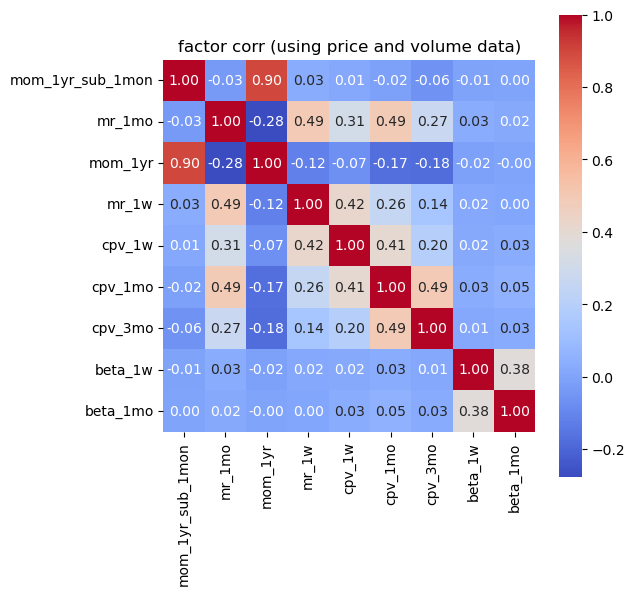

In [44]:
show_corr(factor_and_return_daily_yf_data.corr(), 'factor corr (using price and volume data)')

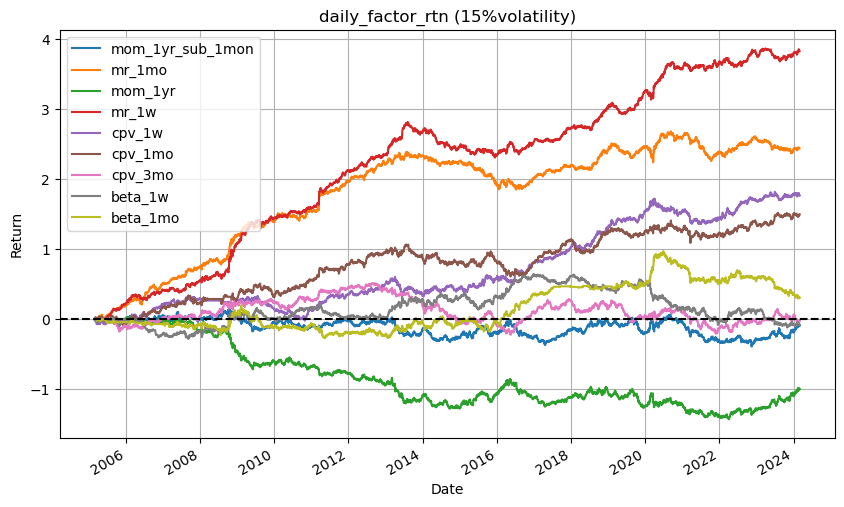

In [45]:
show_cumsum_w_same_volatility(factor_and_return_daily_yf_data,'daily_factor_rtn (15%volatility)')

In [46]:
sharpe_ratio(daily_factor_rtn)

Growth_rps          -0.10
Size                 0.14
Profitability_eps   -0.26
Growth_rev          -0.05
Valuation            0.04
Profitability_roe    0.06
Beta                -0.06
Growth_sales        -0.16
Liquidity           -0.24
dtype: float64

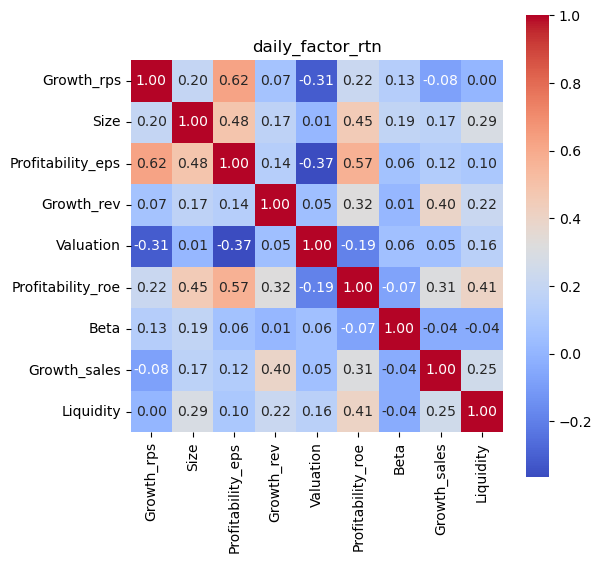

In [47]:
show_corr(daily_factor_rtn.corr(), 'daily_factor_rtn')

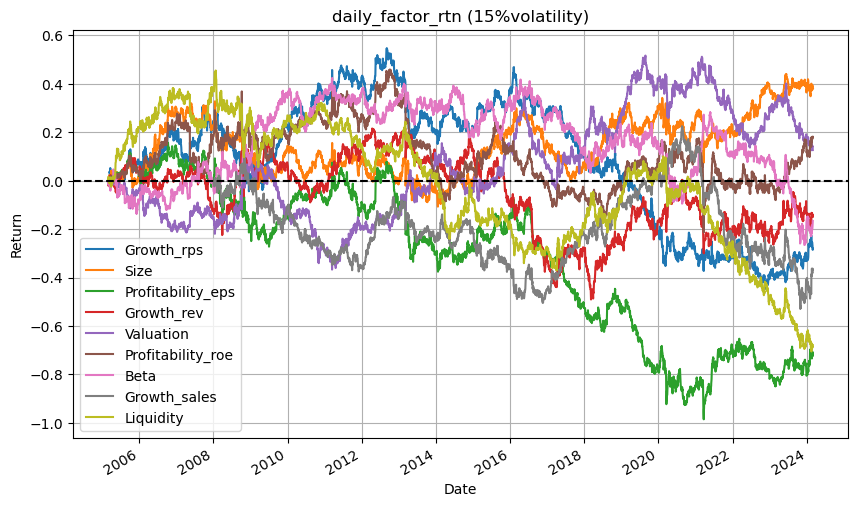

In [48]:
show_cumsum_w_same_volatility(daily_factor_rtn,'daily_factor_rtn (15%volatility)')

In [28]:
factor_selected = ['Size','Liquidity','cpv_1mo','mr_1yr' ,'mr_1w' ]

sharpe_ratio >= 0.14

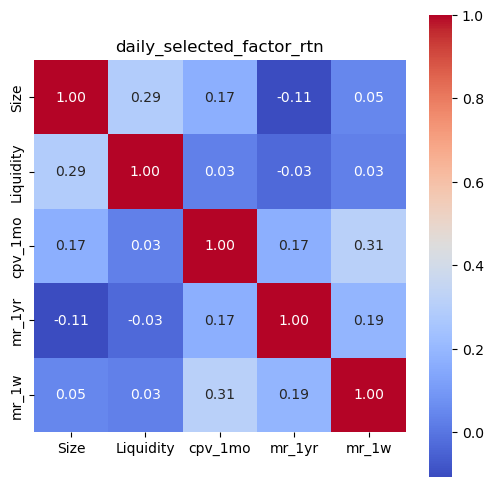

In [29]:
show_corr(daily_factor_rtn[factor_selected].corr(), 'daily_selected_factor_rtn')

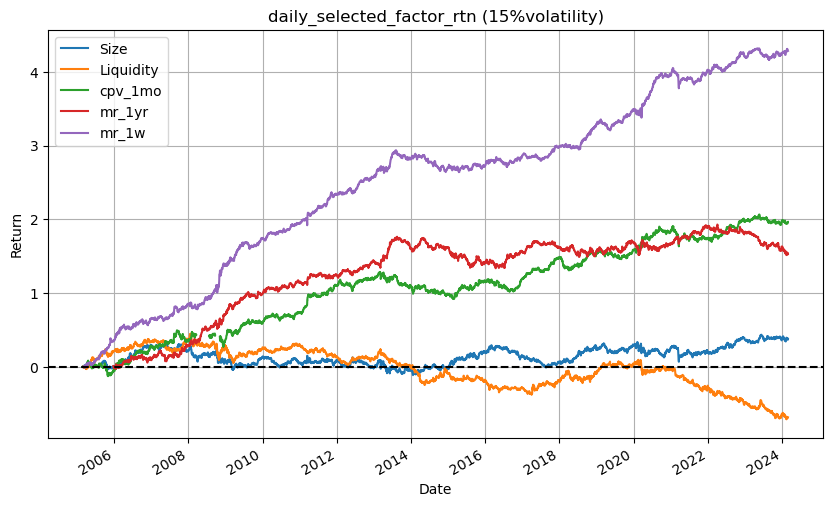

In [30]:
show_cumsum_w_same_volatility(daily_factor_rtn[factor_selected],'daily_selected_factor_rtn (15%volatility)')